In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import catboost as catb

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.simplefilter('ignore')

In [2]:
TRAIN_DATASET_PATH = '/home/alex/Downloads/course_project_train.csv'
TEST_DATASET_PATH = '/home/alex/Downloads/course_project_test.csv'

# Обзор данных

In [3]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

#### Целевая переменная

In [5]:
df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

#### Числовые переменные

In [6]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


#### Категориальные переменные

In [7]:
for col_name in df.select_dtypes(include='object').columns:
    print(col_name)
    print()
    print(df[col_name].value_counts())
    print()
    print()

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64


Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64


Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64


Term

Short Term    5556
Long Term     1944
Name: Term, dtype: int64




### Ряд вспомогательных функций

In [8]:
def fill_missing_value(df, source_df):
    df['Credit Score']=df['Credit Score'].fillna(source_df['Credit Score'].mean())
    df['Annual Income']=df['Annual Income'].fillna(source_df['Annual Income'].mean())
    df['Bankruptcies']=df['Bankruptcies'].fillna(source_df['Bankruptcies'].median())
    df['Months since last delinquent']=df['Months since last delinquent'].fillna(source_df['Months since last delinquent'].mean())
    imr = SimpleImputer(strategy="most_frequent")
    imr = imr.fit(df[['Years in current job']])
    df['Years in current job'] = imr.transform(df[['Years in current job']]).ravel()
    return df



In [9]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [10]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [11]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

### Заполним пропущенные данные в датасете

In [12]:
df = fill_missing_value(df,df)

### Объявляем целевой, числовые и категориальные признаки

In [13]:
df.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default'],
      dtype='object')

In [14]:
TARGET_NAME = 'Credit Default'
FEATURE_NAMES = df.columns.drop([TARGET_NAME]).tolist()

In [15]:
CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts',
       'Years of Credit History', 'Maximum Open Credit',
       'Number of Credit Problems', 'Months since last delinquent',
       'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt', 'Credit Score']

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES

### Приведение типов категориальных переменных для модели catboost

In [16]:
for colname in CAT_FEATURE_NAMES:
    df[colname] = pd.Categorical(df[colname])
    
df[CAT_FEATURE_NAMES].dtypes

Home Ownership          category
Years in current job    category
Purpose                 category
Term                    category
dtype: object

### Скалирования числовых переменных

In [17]:
scaler = StandardScaler()

df_norm = df.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df = df_norm.copy()

### Разбиваем датасет на обучающую и валидационную выборки

In [18]:
X = df[SELECTED_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

In [19]:
X.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03
mean,6.409688e-17,-4.879911e-16,8.967641e-17,-1.913728e-16,-7.831652e-17,1.222888e-15,-2.638499e-16,-1.917873e-16,3.500163e-17,3.139132e-17,3.841372e-17,-1.563416e-16
std,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00
min,-1.597216e+00,-1.109534e-01,-1.860192e+00,-2.033305e+00,-5.897941e-02,-3.409789e-01,-2.369441e+00,-3.370990e-01,-3.715680e-01,-9.118548e-01,-1.535678e+00,-3.963887e-01
25%,-5.784699e-01,-1.109534e-01,-6.378469e-01,-6.841558e-01,-4.155495e-02,-3.409789e-01,-4.852876e-16,-3.370990e-01,-3.662765e-01,-5.523883e-01,-6.915123e-01,-3.032588e-01
50%,0.000000e+00,-1.109534e-01,-2.303985e-01,-1.871009e-01,-2.914137e-02,-3.409789e-01,-4.852876e-16,-3.370990e-01,-3.622230e-01,-2.532962e-01,-1.876539e-01,-2.892543e-01
75%,1.775343e-01,-1.109534e-01,5.844983e-01,4.945743e-01,-9.463390e-03,-3.409789e-01,-4.852876e-16,-3.370990e-01,-3.556352e-01,2.220323e-01,4.614758e-01,0.000000e+00
max,1.167277e+01,2.566362e+01,6.492500e+00,5.592937e+00,8.135844e+01,1.369933e+01,5.689742e+00,1.119423e+01,2.760520e+00,1.955941e+01,9.924941e+00,4.452671e+00


### Балансировка датасета по меньшему классу

In [20]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [21]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

### Обучение модели и проверка её качества

In [22]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 2], n_estimators=1000, max_depth=5,
                                      silent=True, random_state=21, l2_leaf_reg=5)
model_catb.fit(X_train, y_train, cat_features=CAT_FEATURE_NAMES)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.96      0.68      0.80      3771
           1       0.71      0.96      0.82      2958

   micro avg       0.81      0.81      0.81      6729
   macro avg       0.83      0.82      0.81      6729
weighted avg       0.85      0.81      0.81      6729

TEST

              precision    recall  f1-score   support

           0       0.85      0.57      0.68      1616
           1       0.41      0.75      0.53       634

   micro avg       0.62      0.62      0.62      2250
   macro avg       0.63      0.66      0.61      2250
weighted avg       0.73      0.62      0.64      2250

CONFUSION MATRIX

col_0           0.0  1.0
Credit Default          
0               923  693
1               159  475


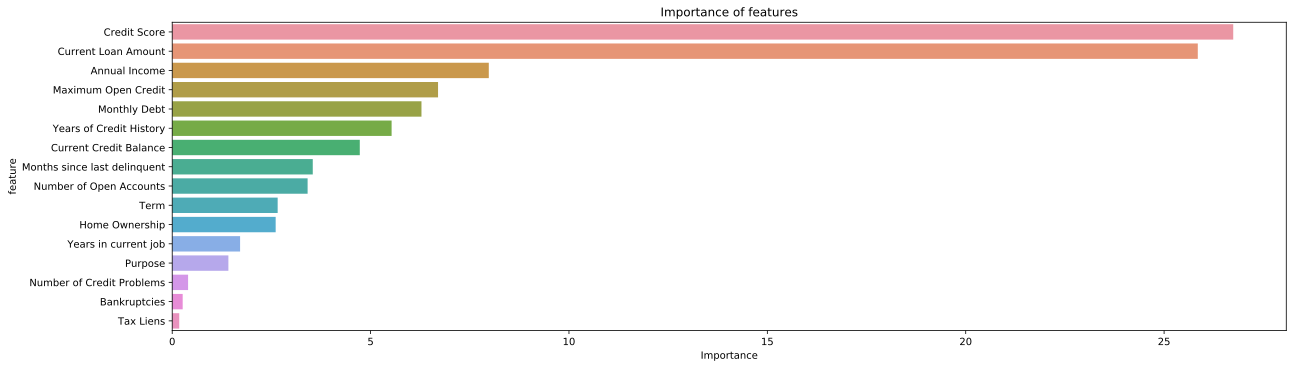

In [23]:
important_features_top = show_feature_importances(X_train.columns, model_catb.feature_importances_, get_top=15)